This notebook is based on *Lesson 6* of the **Deep Learning with PyTorch** MOOC from Udacity. 

# Setting Up Libraries

Setting up the environment of this notebook. This notebook is intended to run always using Google Colaboratory.

In [0]:
# Installing PyTorch with cuda support and TorchVision
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [6]:
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 16.2MB/s 


After updating *pillow* version installed, you should **restart the runtime**. 

(Runtime -> Restart runtime...)


# Sync with Github

Sync with the [Style Transfer Github repository](https://github.com/pedroprates/style-transfer) to download all the conents on the Google Colab system. Make sure that the runtime type is Python 3 and GPU enabled (Runtime -> Change Runtime Type). 

In [1]:
!git clone https://github.com/pedroprates/style-transfer.git

fatal: destination path 'style-transfer' already exists and is not an empty directory.


In [0]:
import os
os.chdir('style-transfer')

In [3]:
# Choose the desired branch. When cloning a repository the default branch is "master", but right
# now the right one for development is style-model
!git checkout style-model

Already on 'style-model'
Your branch is up to date with 'origin/style-model'.


# Style Transfer



The Style Transfer method developed in this notebook is based on the paper [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) using the framework PyTorch. In this paper, Style Transfer uses a pre-trained 19-layer VGG network. 

## Separating Style and Content

Style transfer relies onn separating the content and style of an image. Given one content image and one style image, we aim to create a new *target* image which should contain our desired content and style components:

* objects and their arrangements are similar to that of the **content image**
* style, colors and texture are similar to that of the **style image**

In this notebook we'll use a VGG-19 network to extract the features of the content and style images, and we'll update the pixels of the *target* image to minimize the article's loss function.

In [0]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models, utils


## CUDA

Checking if CUDA is available! Again, this notebook is supposed to be running on the Google Colab environment, so CUDA **must** be available. If not, check the runtime options at *Runtime* -> *Change Runtime Type*.

In [0]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load VGG-19

VGG19 in particular is separated in two parts:

* `vgg19.features` - the convolutional and pooling layers
* `vgg19.classifier` - the classifier, the fully-connected layers 

For this task, since we're not trying to classify anything, and only using the network to extract features, we'll only be using the features part. And we'll also *freeze* the weights, to avoid any training.

In [0]:
def get_model():
  vgg19 = models.vgg19(pretrained=True).features

  # freeze weights
  for param in vgg19.parameters():
    param.requires_grad_(False)
  
  device = get_device()
  
  vgg19.to(device)
  
  return vgg19

## Load the Content and Style Images

The functions below it's provided to load images, any images you want (after they are loaded in the colab's environment). To help the algorithm perform better, it's usual that the *style* and *content* images are the same sizes. As we're trying to copy the content of one image, and the content could suffer a bigger impact on reshaping, we'll force the *style* image to be the same shape as the *content* image.

```python
def load_image(path)
```

```python
def load_tensors(content_path, style_path)
```

A helper funtion to process the given *Torch Tensor* to an image and then plot (or save) it. 

```python
def process_to_image(tensor)
```

In [0]:
def load_image(img_path, max_size=400, shape=None):
  ''' Load in and transform an image. 
      The image should have x-y dimensions smaller than 400px.
      
      This function will return a Torch Tensor
  '''
  
  image = Image.open(img_path).convert('RGB')
  
  if shape is not None:
    size = shape
  else:
    size = max(image.size) if max(image.size) <= max_size else max_size
    
  in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406),
                           (0.229, 0.224, 0.225))])
  
  # Discarding the alpha channel (for transparency) and adding
  # the batch dimension
  image = in_transform(image)[:3, :, :].unsqueeze(0)
  
  return image

In [0]:
def load_tensors(content_path, style_path, max_size=400):
  ''' Load both tensors, content and style.
      Receive the paths together with the settings (max_size),
      and then returns the content and style tensors, which should
      be the same size.
  
  '''
  device = get_device()
  
  content = load_image(content_path, max_size).to(device)
  style = load_image(style_path, shape=content.shape[-2:]).to(device)
  
  return content, style

In [0]:
def process_to_image(tensor):
  ''' This function will receive a tensor and return 
      an image, un-normalized and ready to be plotted
      or saved.
  '''
  
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  
  return image

In [0]:
def plot_images(content, style, titles=['Content', 'Style']):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
  
  ax1.imshow(process_to_image(content))
  ax1.grid(None)
  ax1.set_title(titles[0])
  
  ax2.imshow(process_to_image(style))
  ax2.grid(None)
  ax2.set_title(titles[1])

### Testing the functions

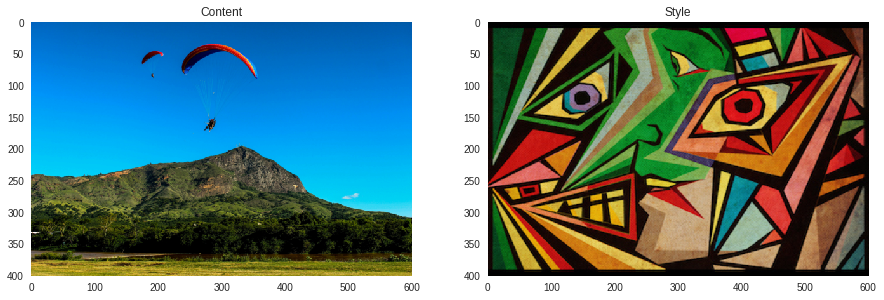

In [85]:
content, style = load_tensors('images/ibituruna.jpg', 'images/picasso.jpg')
plot_images(content, style)

## Content and Style Features

The function below will get the important layers of the network, the ones which will be used to calculate the content and style features. Those layers were chosen by the article this notebook is based, Gatys et al (2016). 

```python
def get_features(image, model, layers=None)
```

In [0]:
def get_features(image, model, layers=None):
  ''' Run an image forward through a model and get the features
      for a set of layers.
  '''
  
  # Important layers for style and content definition
  if layers is None:
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10':'conv3_1',
        '19':'conv4_1',
        '21':'conv4_2',
        '28':'conv5_1'
    }
  
  features = {}
  x = image
  
  for name, layer in model._modules.items():
    x = layer(x)
    
    if name in layers:
      features[layers[name]] = x
      
  return features

## Gram Matrix

The **Gram Matrix** is important to calculate part of the style loss of the network. And will be calculated for each tensor as the function below:

```python
def gram_matrix(tensor)
```

In [0]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h*w)
  
  gram = torch.mm(tensor, tensor.t())
  
  return gram

## Get the initial features

Get the features of the *content* and *style* images. Also get the gram matrix values for each of the desired layers on the *style* image. The **target** image will start as the *content* image, and each of its pixels will be updated via *backpropagation* based on the loss function.

```python
def define_features(content, style, model)
```

Each relevant layer could be mulitiplied by a weight. By weighting earlier layers more, it could be expected that the **target** image will have more visual style artifacts. It's suggested that the weights should be between 0 and 1.

```python
def define_weights()
```

In [0]:
def define_features(content, style, model):
  device = get_device()
  
  content_features = get_features(content, model)
  style_features = get_features(style, model)
  
  style_grams = { layer: gram_matrix(style_features[layer]) for layer in style_features }
  
  target = content.clone().requires_grad_(True).to(device)
  
  return content_features, style_features, style_grams, target

In [0]:
def define_weights():
  style_weights = {'conv1_1': 1.,
                   'conv2_1': 0.75,
                   'conv3_1': 0.2,
                   'conv4_1': 0.2,
                   'conv5_1': 0.2 }
  
  content_weight = 1 # alpha
  style_weight = 1e6 # beta
  
  return style_weights, content_weight, style_weight

## Building the target

The process of building the **target** image could be seen as a training process where instead of the parameters of the network, the pixels of the input image are updated to get the loss function lower. Given that we're only wanting to change one picture, there will be no batches or training sets, the only image to be fed to the network will be the **target** image, which the pixels will be updated, and the loss function will be calculated based on the *content* and *style* images.

### Content Loss

The content loss will be the *mean squared difference* between the target and content features at layer `conv4_2`, such as defined on the article.

### Style Loss

The style loss is calculated in a similar way, but you'll have to iterate over a number of layers, that are also defined on the article, and on this notebook will be a dictionary defined by `style_weights`. The *gram matrix* of the **target** image will be calculated and compared at the *gram matrices* from the *style* image, layer by layer. At the end, this loss is normalized by the size of the layer.

### Total Loss

At the end the **total loss** will be the sum of the *content loss* and the *style loss* weightened by $\alpha$ and $\beta$ values. The function below will plot not only the loss (which will be a large number) but also the **target** image intermediate steps. You should focus on the appearance of the **target** image to check the results, but it's fun to also check that the loss function is decreasing over iterations.

```python
def stylify(content, style, model):
```

In [0]:
def assert_filename(name):
  if '.' in name:
    name = name.split('.')[0] + '.png'
  else:
    name = name + '.png'
    
  return name

In [0]:
def stylify(content, style, model, steps=5000, lr=0.003, show_every=500, save=False, filename=''):
  
  content_features, style_features, style_grams, target = define_features(content, style, model)
  style_weights, content_weight, style_weight = define_weights()
  optimizer = optim.Adam([target], lr=lr)
  print('Starting to paint...')
  
  for ii in range(1, steps+1):
    target_features = get_features(target, model)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
      target_feature = target_features[layer]
      _, d, h, w = target_feature.shape
      
      target_gram = gram_matrix(target_feature)
      style_gram = style_grams[layer]
      
      layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
      
      style_loss += layer_style_loss / (d * h * w)
      
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # Update target
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Display picture
    if ii % show_every == 0:
      print('Total Loss: ', total_loss.item())
      plt.imshow(process_to_image(target))
      plt.grid(None)
      plt.title(ii)
      plt.show()
      
  if save:
    assert len(filename) > 3, "File should have a name with more than 3 letters"
    filename = assert_filename(filename)
    
    im_to_save = process_to_image(target)
    im = Image.fromarray((im_to_save * 255).astype(np.uint8))
    
    save_path = 'images/' + filename
    im.save(save_path)
    
    print('Image saved at ' + save_path)
    
    return target

In [0]:
def display_results(content, style, target):
  content_image = process_to_image(content)
  style_image = process_to_image(style)
  target_image = process_to_image(target)
      
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
  
  ax1.tick_params(axis='both',
                  which='both',
                  bottom=False,
                  left=False,
                  labelbottom=False,
                  labelleft=False)
  
  ax1.grid(None)
  ax1.imshow(content_image)
  ax1.set_title('Content')
  
  ax2.tick_params(axis='both',
                  which='both',
                  bottom=False,
                  left=False,
                  labelbottom=False,
                  labelleft=False)
  
  ax2.grid(None)
  ax2.imshow(style_image)
  ax2.set_title("Style")
  
  ax3.tick_params(axis='both',
                  which='both',
                  bottom=False,
                  left=False,
                  labelbottom=False,
                  labelleft=False)
  ax3.grid(None)
  ax3.imshow(target_image)
  ax3.set_title('Target')

# Style your Image!

After running all the code above, you have all the power you need to style your image! Feel free to choose your own images, upload them to the Google Colaboratory environment and change the code below to style your own images! 

You can choose a different number of steps and learning rate to check if the results will be better, but it's recommended at least 5000 steps to nice pictures :-) 

*Enjoy the power of Google's GPU!*

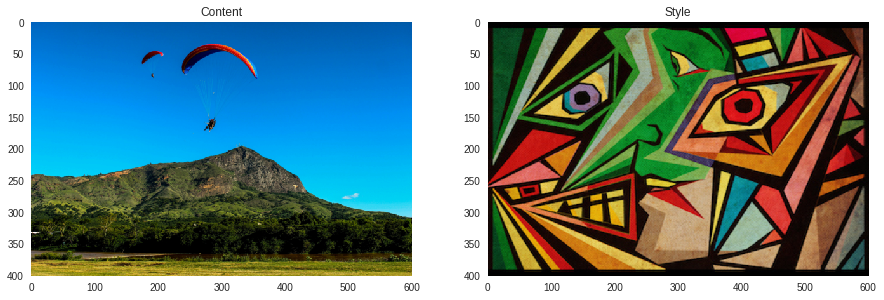

In [93]:
content, style = load_tensors('images/ibituruna.jpg', 'images/picasso.jpg')
plot_images(content, style)

In [0]:
vgg = get_model()

In [106]:
target = stylify(content, style, vgg, save=True, filename='ibituruna_picasso')

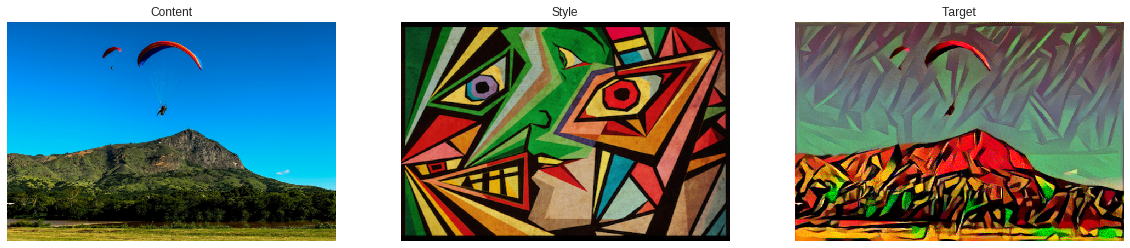

In [112]:
display_results(content, style, target)